# Lab 3 - Explaining Deep Learning Models

#### Topics:
- Occlusion
- Unsupervised Explainers
- Gradient Based Explainers
- DeepSHAP (DeepLift)
- Attacks and Defence using Adversarial Features

In [31]:
# !pip install torch
# !pip install torchvision
# !pip install opencv-python


In [1]:
import numpy as np
import os
import torch
torch.manual_seed(0)
import torchvision
import torchvision.models as models
from IPython.display import display
import PIL
import ast
import cv2
from utils import preprocess_image
from utils import preprocess_image, overlay_heatmap_on_image
from gradcam import GradCam

In [2]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
IMAGE_NET_CLASSES_FILE = 'imagenet_classes'
IMAGE_NET_CLASSES_FILE_FMT = 'txt'
with open(os.path.join(os.getcwd(), f'{IMAGE_NET_CLASSES_FILE}.{IMAGE_NET_CLASSES_FILE_FMT}'), 'r') as f:
    classes = ast.literal_eval(f.read())
# look up the classes from here when needed below
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [4]:
IMAGE_DIR = 'test_images'
IMAGE_DIR_PATH = os.path.join(os.getcwd(), IMAGE_DIR)
PICTURE_FMT = 'jpg'

to_image_path = lambda file_name: os.path.join(IMAGE_DIR_PATH, f'{file_name}.{PICTURE_FMT}')

## 1) Occlusion

### a) Use the provided starter code to generate areas of importance in classification of random images.

##### Use the Heatmap to explain qualitatively how well the pre-trained model is able to understand the object of the image.

We have given a running example for a basketball image, but continue your exploration for all other images in the directory.

In [5]:
# Starter Code for Creating Occlusions and Generating a Combined HeatMap Image- Note there are better ways of making occlusions by using data augmentation libraries but we want to keep our focus away from those techniques at the moment.

loss_function = torch.nn.MSELoss()
def generate_area_importance_heatmap_with_occlusions(image, annotation, block_size=14):
    image = np.array(image)

    height, width, channels = image.shape

    columns = width // block_size
    rows = height // block_size

    heatmap = np.zeros((columns, rows))

    for row in range(rows):
        for column in range(columns):
            x = column * block_size
            y = row * block_size

            top = int(y)
            left = int(x)
            right = left + block_size
            bottom = top + block_size

            tmp_image = np.copy(image)

            noise = np.random.rand(block_size, block_size, 3) * 255
            tmp_image[int(top):int(bottom), int(left):int(right)] = noise
            tmp_image = PIL.Image.fromarray(tmp_image)

            preprocessed_image = preprocess_image(tmp_image)
            prediction = resnet_model(preprocessed_image).clamp(min=-1, max=1)
            loss = round(float(loss_function(prediction, annotation)), 4)

            heatmap[column, row] = loss

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = heatmap * 255
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_NEAREST)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlayed = cv2.addWeighted(image, 1, heatmap, 0.75, 0)
    combined = np.concatenate((image, heatmap, overlayed), axis=1)

    return combined

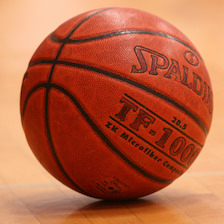

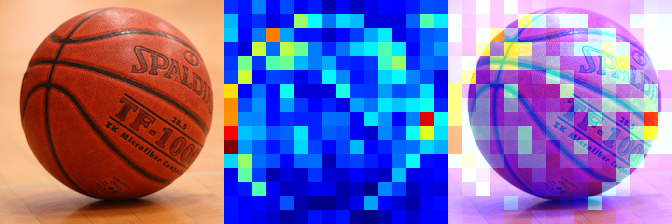

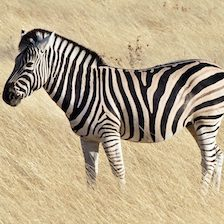

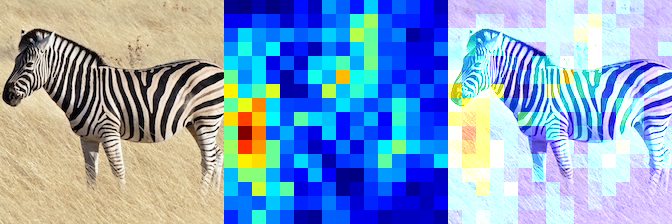

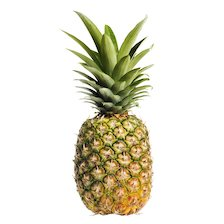

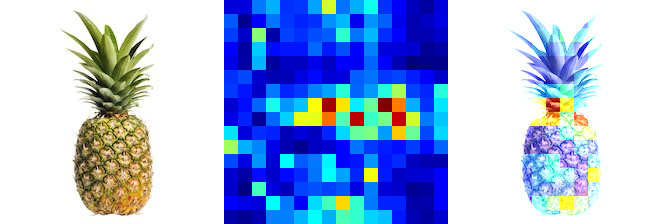

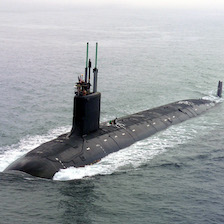

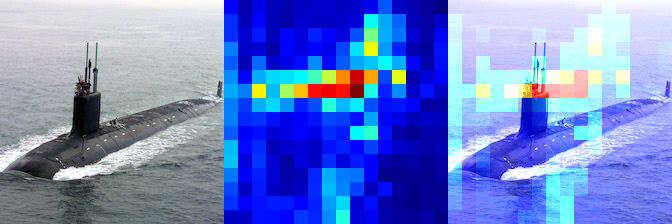

In [6]:
PINEAPPLE_TEST_IMAGE_PATH = to_image_path('pineapple')
BASKETBALL_TEST_IMAGE_PATH = to_image_path('basketball')
SUBMARINE_TEST_IMAGE_PATH = to_image_path('submarine')
ZEBRA_TEST_IMAGE_PATH = to_image_path('zebra')
SUB_AIRCRAFT_CARRIER_IMAGE_PATH = to_image_path('submarine_and_aircraft_carrier')

TEST_IMAGE = PIL.Image.open(BASKETBALL_TEST_IMAGE_PATH)
display(TEST_IMAGE)
preprocessed_image = preprocess_image(TEST_IMAGE)
output = resnet_model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE), output)
display(PIL.Image.fromarray(occlusion_importance_heatmap))

TEST_IMAGE1 = PIL.Image.open(ZEBRA_TEST_IMAGE_PATH )
display(TEST_IMAGE1)
preprocessed_image = preprocess_image(TEST_IMAGE1)
output1 = resnet_model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE1), output1)
display(PIL.Image.fromarray(occlusion_importance_heatmap))

TEST_IMAGE2 = PIL.Image.open(PINEAPPLE_TEST_IMAGE_PATH)
display(TEST_IMAGE2)
preprocessed_image = preprocess_image(TEST_IMAGE2)
output2 = resnet_model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE2), output2)
display(PIL.Image.fromarray(occlusion_importance_heatmap))


TEST_IMAGE3 = PIL.Image.open(SUBMARINE_TEST_IMAGE_PATH)
display(TEST_IMAGE3)
preprocessed_image = preprocess_image(TEST_IMAGE3)
output3 = resnet_model(preprocessed_image)
occlusion_importance_heatmap = generate_area_importance_heatmap_with_occlusions(np.array(TEST_IMAGE3), output3)
display(PIL.Image.fromarray(occlusion_importance_heatmap))




##### Explanation
- Region where the heatmap is brighter or has red/yellow colour shows that the areas tend to contain distinctive features or patterns relevant to the object's identification. In contrast, region where the heatmap has cooler colour like blue or purple indicates that these regions may not contain important information for identifying the object. For example, given the basketball image, the model predominantly focuses on the round shape and the texture of the basketball itself, which means the model is understanding the object well. In the case of the pineaple image, the model focuses on the spiky texture of the pineaple skin and its crown. Or the zebra image, the model emphasizes the black and white stripes, as well as the general shape of a zebra. Regarding the submarine image, the model recognizes the unique feature of the submarine and the background (water) elements to make a classification decision. In conclusion, the heatmap does focus on the distinguishing features and characteristics of the objects.

### b) Explain what is important in chosen data set, so that what we as humans intuitively use to identify objects, can be learnt by the machine.

Hint: refer back to lecture with example of on mis-classification.

##### Answer:
Important considerations when creating a dataset that aligns with human intuition:
- Capture images of the object from multiple angles to help the model learn how to recognize them from different viewpoints
- Provide images of the object in different backgrounds and environments to help the model learn to focus on the object itself rather than relying solely on the context for classification. This helps to reduce the variations of the context.
- Introduce noise in the data to simulate real-world conditions. This can include variations in lighting, blurriness to help the model become more robust.
- Apply data augmentation techniques such as rotation, scaling, cropping, and flipping to artificially increase the size of your dataset. This provides the model with additional training examples and helps it generalize better.
- Ensure the dataset includes examples that cover the intra-class variability (for example: within a single object class (ball), there can be different types: basketball, football, tennis bal,..) to prevent the model from making overly simplistic assumptions.

## 2) Unsupervised Explainers

Note: This does not require a deep learning model.

In [7]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load Digits dataset
X, y = datasets.load_digits(return_X_y=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=0
)

dim = len(X[0])
n_classes = len(np.unique(y))

### a) Using PCA find the number of dimensions (axis) with the most variance (i.e. the components have at least 0.1 variance)

In [8]:
pca_results = PCA(n_components=0.95)  # initialise PCA method
pca_results.fit(X_train)
print(pca_results.explained_variance_ratio_[:10])  # print the internal calculations

[0.14970648 0.13456822 0.1209727  0.0829049  0.06002415 0.04938589
 0.04400294 0.0369694  0.03352646 0.02962838]


### b) Perform PCA and t-SNE on the Fashion-MNIST dataset using the given the starter code.

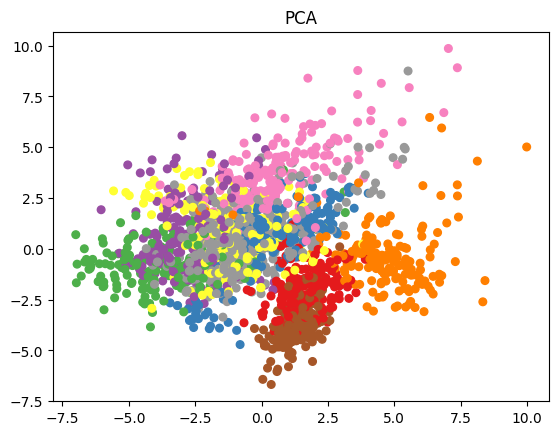

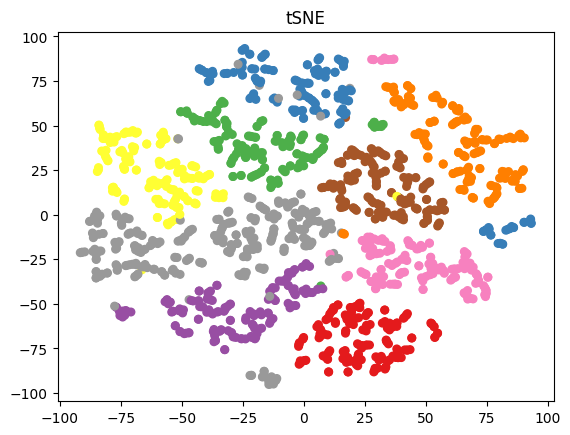

In [9]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))
tSNE = TSNE(n_components=2, init='random', perplexity=3, learning_rate='auto', random_state=0)
  #TODO: add method for tSNE with 2 components, random initialisation and perplexity 3 and auto learning rate.

dim_reduction_methods = [("PCA", pca), ("tSNE", tSNE)]

for i, (name, dim_reduction_model) in enumerate(dim_reduction_methods):
    plt.figure()
    # TODO: Fit the method's model
    dim_reduction_model.fit(X)
    # Embed the data set in 2 dimensions using the fitted model
    if name == "PCA":
        X_embedded = dim_reduction_model.transform(X)
    else:
        X_embedded = dim_reduction_model.fit_transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(f"{name}")
plt.show()

### c) Explain what can be interpreted using an unsupervised method like this in explaining an incorrect classification.

##### Answer:
PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) are both dimensionality reduction techniques commonly used in machine learning and data analysis.

1. **PCA (Principal Component Analysis)**:
   - PCA is a linear dimensionality reduction technique.
   - It's used to reduce the number of features (dimensions) in a dataset while preserving as much variance as possible.
   - PCA identifies the principal components (linear combinations of the original features) that capture the most variance in the data.
   - These principal components are sorted by their explained variance, and you can choose to keep a certain number of them to reduce the dimensionality.
   - PCA is a widely used technique for data preprocessing and visualization.

2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
   - t-SNE is a non-linear dimensionality reduction technique.
   - It's primarily used for visualization because it tries to preserve the pairwise similarities between data points.
   - t-SNE works by modeling the similarity between data points in the high-dimensional space and the low-dimensional space (typically 2D or 3D).
   - It focuses on preserving the relative distances between data points rather than the global structure, making it well-suited for visualizing clusters and patterns in data.
   - t-SNE is often used for exploratory data analysis and visualization of high-dimensional data.

The code is using PCA to reduce the dimensionality of your data to 2 dimensions, which is common for visualization purposes. You are also attempting to use t-SNE with 2 components for the same purpose. Both methods aim to provide a lower-dimensional representation of your data while preserving important information, but they do so in different ways (linear vs. non-linear) and may yield different results depending on the nature of your data.


## 3) Gradient Based Explainers

### a) Use the given data set and pretrained model to generate heatmap overlay for which part of the image explains the classification, i.e. perform a CAM for a random image.

A running example of aircraft carrier and submarine is given

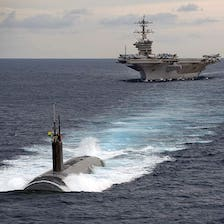

0 imagenet_idx=833 submarine, pigboat, sub, U-boat
1 imagenet_idx=403 aircraft carrier, carrier, flattop, attack aircraft carrier


In [10]:
TEST_IMAGE = PIL.Image.open(SUB_AIRCRAFT_CARRIER_IMAGE_PATH)
display(TEST_IMAGE)
preprocessed_image = preprocess_image(TEST_IMAGE)

output = resnet_model(preprocessed_image)
softmax = torch.softmax(output, dim=1)

top2 = torch.topk(softmax, 2).indices.numpy()

for idx, class_idx in enumerate(top2[0]):
    print(idx, f'imagenet_idx={class_idx}', classes[class_idx])

0 imagenet_idx=833 submarine, pigboat, sub, U-boat


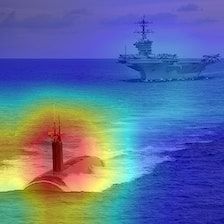

1 imagenet_idx=403 aircraft carrier, carrier, flattop, attack aircraft carrier


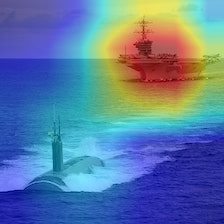

In [11]:
gradcam = GradCam(model=resnet_model, target_layer=resnet_model.layer4, target_layer_names=["1"])

def generate_cam_overlay_for_target_class(processed_image, target_class=None):
    img = np.array(TEST_IMAGE)
    img = img[:, :, ::-1].copy()
    img = np.float32(img) / 255

    cam_heatmap = gradcam(processed_image, target_class)
    cam_overlay = overlay_heatmap_on_image(img, cam_heatmap)
    return cam_overlay

for idx, class_idx in enumerate(top2[0]):
    print(idx, f'imagenet_idx={class_idx}', classes[class_idx])
    cam_overlay = generate_cam_overlay_for_target_class(preprocessed_image, class_idx)
    display(PIL.Image.fromarray(cv2.cvtColor(cam_overlay, cv2.COLOR_BGR2RGB)))

### b) Explain how when there are multiple objects in a frame, this could be used identify each object individually.

##### Explanation
- The code above use the gradcam instance to compute the Grad-CAM heatmap for the specified target class (target_class) on the preprocessed image. Then it generates and displays a heatmap overlay that highlights the regions of the image that contributed most to the classification of the submarine class. The submarine_cam_overlay visually shows which parts of the image were most important in making this classification decision
- When there are multiple objects in a frame, after detecting the object, we can apply Grad-CAM to generate class activation maps (CAM) for each detected object. Grad-CAM highlights the regions in the image that were most relevant to the classification of a specific class. Then, for each detected object, we  apply Grad-CAM individually by:
    + Cropping the region of interest (ROI) from the original image using the bounding box coordinates provided by the object detection model.
    + Preprocessing the cropped ROI for input to Grad-CAM.
    + Running Grad-CAM on this preprocessed ROI to generate a heatmap specific to that object.
- Then, we create overlaying heatmaps onto the corresponding cropped ROI. This overlay provides a visualization of which parts of the object have the most contribution to its classification.
- By examining the heatmaps and the object detection results, we can identify and label each object individually. The object detection model gives the class labels, while the Grad-CAM heatmaps help us understand which regions of each object were crucial for classification.
- Finally, we display the original image with the bounding boxes and class labels from the object detection model and overlay the Grad-CAM heatmaps for each object.


## 4) DeepSHAP (DeepLift)

In [12]:
# imports for a deep learning model
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### a) Use the shap library and the provided starter code to explain the MNIST data set.

In [13]:
# simple code for training a deep learning model with pyTorch
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model_to_train, train_on, train_data_loader, optimizer_func, epoch_num):
    model_to_train.train()
    for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(train_on), target.to(train_on)
        optimizer_func.zero_grad()
        output = model_to_train(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer_func.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, batch_idx * len(data), len(train_data_loader.dataset),
                           100. * batch_idx / len(train_data_loader), loss.item()))

def test(model_to_test, train_on, test_data_loader):
    model_to_test.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(train_on), target.to(train_on)
            output = model_to_test(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_data_loader.dataset),
    100. * correct / len(test_data_loader.dataset)))

In [14]:
resnet_model = Net().to(device)
optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.5)

batch_size = 128
num_epochs = 2

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'mnist_data',
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'mnist_data',
        train=False,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size, shuffle=True
)

for epoch in range(1, num_epochs + 1):
    train(resnet_model, device, train_loader, optimizer, epoch)
    test(resnet_model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320004
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.270785
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.947613
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.186485
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.757515

Test set: Average loss: 0.0057, Accuracy: 8761/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.752779
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.825380
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.614524
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.536821
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.671216

Test set: Average loss: 0.0030, Accuracy: 9287/10000 (93%)



Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


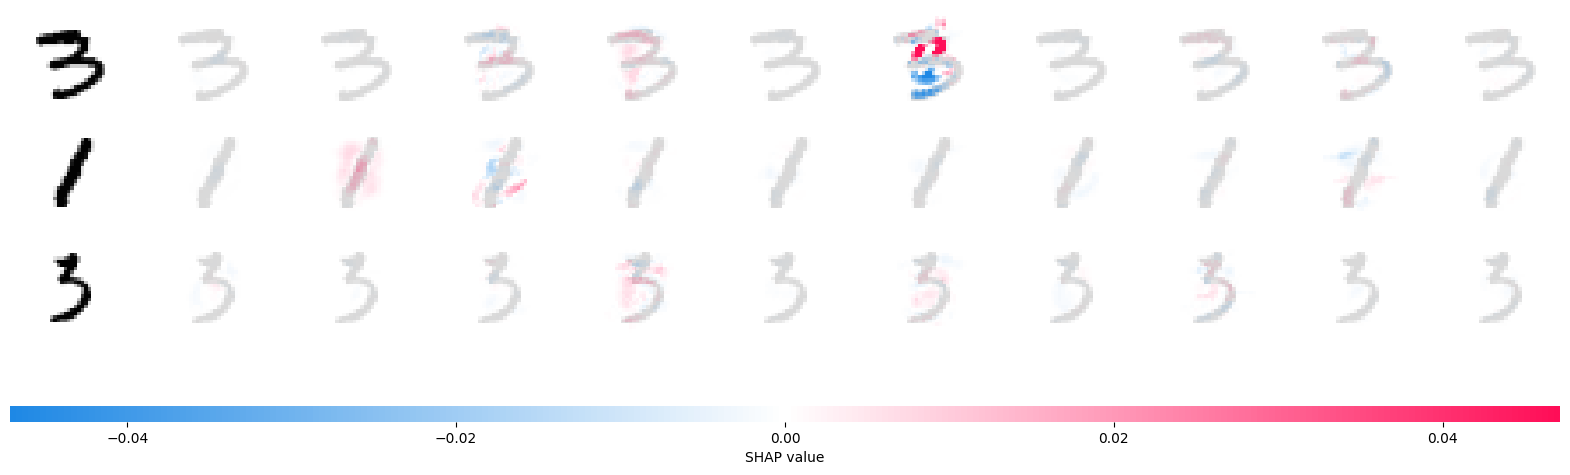

In [15]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

explainer = shap.DeepExplainer(resnet_model, background)  # TODO: use the DeepExplainer on the model and background
shap_values = explainer.shap_values(test_images)  # TODO: find the shap values using the explainer for the test_images

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

### b) Explain what can be understood about the similarity of certain digits as seen by the machine learning model through the explanations.

##### Answer:
SHAP values provide information about the contribution of each pixel to the model's predictions:
- Shared Features: SHAP values can reveal which pixels are considered important by the model when making predictions for specific digits. Pixels that consistently have positive or negative SHAP values for multiple digits suggest shared features that are used to identify those digits. For example, the presence of a vertical line on the left side of the image may contribute positively to the prediction of the digits "1" and "7"
- Overlapping Features: In some cases, we may observe pixels with mixed SHAP values for multiple digits. These pixels could be part of shared features that overlap with distinctive features. For example, an "6", "8" might  have a circular shape in the bottom of the image, but other features differentiate them.


## 5) Attacks and Defence using Adversarial Features

### a) Read the article [NeurIPS 2017 - Adversarial Attacks and Defences Competition](https://arxiv.org/pdf/1804.00097.pdf), mainly Section 2.2 and 2.3 and explain the general idea what the attack and defence try to achieve. (Explain at least 2 different of each attack and defence)

##### Answer:


Attacks:

Attacks mentioned in Section 2.2 aim to exploit weaknesses in machine learning models, especially neural networks, by introducing small perturbations to the input data that cause the model to make incorrect predictions. 

L-BFGS (White box attack):
It aims to find the smallest adversarial perturbation to an input image.
Uses the L-BFGS optimization technique.
Slow and can be defeated by simple defenses like image quality degradation.

Substitute Models with Probes (Black box attack):
If the attacker can send probes (test queries) to the model, they can replicate its decision boundaries.
The substitute is trained not just as a classifier but to reverse engineer the target model.

Defenses:

It is difficult to defend against adversarial attacks, and no strategy has yet proven to be fully effective. Although many of these solutions show promise, they come with trade-offs and are frequently overcome by skilled attackers. This field of research is ongoing.

Gradient Masking: This technique aims to hide the gradients of the model, making it difficult for an attacker to find useful gradients. Since many white-box attacks rely on model gradients. However, this technique doesn't alter the actual decision boundaries of the model, which means black box attacks can still be effective.

Adversarial Training: Include adversarial examples in the training data. By training on both clean and adversarial examples, the model learns to be robust against those attacks. However, this approach has its drawbacks, such as; Overfitting to specific attacks or to specific constraint regions, leading to vulnerabilities in other regions.
